In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt


from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,5)



In [2]:
########################################
# Constants and options
kgC_to_umolsCO2_factor =  (1e3/12.0107)*1e6  #(grams of substance/molar mass) * micromoles conversion
seconds_in_year = 60.*60.*24.*365.
Lc_H2O = 2.501e6


In [3]:
# Directories and Filenames
BASE_DIR='/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/'

plotcolors=['b','r','g','m','y','orange','k']
site='AliceHolt'
year_str='2005'
ipft=0
runids=['Jv4.6_'] 
rosetags=['','','']#,'_Rose']
#,'Jv4.6_AliceHolt_Rose','Jv4.6_tefld_AliceHolt_Rose']'Jv4.6_tefld_','Jv4.6_MEGANemis_','Jv4.6_','Jv4.6_tefld_EMEPemis_',
runids=[runid+site+rose for runid,rose in zip(runids,rosetags)]
tstep='tstep'
nJULES=len(runids)
JULES_OUTPUT_DIR=BASE_DIR+'jules_runs/output/'+site+'/'
JULES_fnames=[JULES_OUTPUT_DIR+runid+'.'+tstep+'.nc' for runid in runids]
#print(JULES_fnames)

SITE_DIR=BASE_DIR+'data/'
SITE_fname=SITE_DIR+'Isoprene_Flux_'+site+'_'+year_str+'.nc'
SITE_GPP_file=SITE_DIR+'FLUX_DATA_022017/UKHam_2005_JULES_drivefluxdata.nc'



In [5]:

# Read Site Data
Svars=['isoprene','isoprene_err']
print(SITE_fname)
Sinf=nc.Dataset(SITE_fname,'r')
S_Dict1={}
for var in Svars:
    S_Dict1[var]=Sinf.variables[var][:].squeeze()

roundtime= np.round(Sinf.variables['time'][:].astype('float64')/1800.)*1800.
S_time1=nc.num2date(roundtime,Sinf.variables['time'].units)
del roundtime
Sinf.close()
S_panda1=pd.DataFrame(S_Dict1,index=S_time1)

Svars=['gpp','co2_flux','ter','t','co2_atm','pstar']
Sinf=nc.Dataset(SITE_GPP_file,'r')
S_Dict2={}
for var in Svars:
    S_Dict2[var]=Sinf.variables[var][:].squeeze()

roundtime= np.round(Sinf.variables['time'][:].astype('float64')/1800.)*1800.
S_time2=nc.num2date(roundtime,Sinf.variables['time'].units)
del roundtime
Sinf.close()
S_panda2=pd.DataFrame(S_Dict2,index=S_time2).resample('H').mean()

S_panda=pd.concat([S_panda1,S_panda2],axis=1)


/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/data/Isoprene_Flux_AliceHolt_2005.nc


In [6]:
# Read in JULES data and convert to pandas
Jvars=['isoprene_gb','terpene_gb','lai','tstar_gb','gpp_gb','npp_gb',\
       'fsmc_gb','sw_down','precip','co2_mmr','lw_down',\
       'ftl_gb','fqw_gb','esoil_gb','ecan_gb','runoff', \
       't1p5m_gb','pstar']#,'tl1','gpp_gb']
J_pandas=[]

for Jcnt in range(nJULES):
    print(JULES_fnames[Jcnt])
    Jinf=nc.Dataset(JULES_fnames[Jcnt],'r')
    
    J_Dict={}
    for var in Jvars:
        J_Dict[var]=Jinf.variables[var][:].squeeze()
        if len(J_Dict[var].shape)>1:
            J_Dict[var]=J_Dict[var][:,ipft]
    for i in range(4):
        J_Dict['sthu_'+str(i)]=Jinf.variables['sthu'][:,i,:].squeeze()
        
    roundtime= np.round(Jinf.variables['time'][:].astype('float64')/1800.)*1800.
    J_time=nc.num2date(roundtime, Jinf.variables['time'].units)
    del roundtime
    Jinf.close()
    
    J_pandas.append( pd.DataFrame(J_Dict,index=J_time) )

/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/jules_runs/output/AliceHolt/Jv4.6_AliceHolt.tstep.nc


In [21]:
J_Dict['gpp_gb'][:24]

array([ -5.96855897e-22,   2.55795381e-22,   7.46069934e-23,
         5.32906465e-24,  -1.59872129e-22,  -1.06581411e-23,
        -7.99360581e-23,   1.40720310e-10,   5.11679366e-10,
         8.52931947e-10,   1.57696067e-09,   2.00486361e-09,
         1.48178414e-09,   1.29758693e-09,   5.51813983e-10,
         3.74264128e-16,  -4.68958194e-22,  -4.26325424e-23,
        -4.26325626e-22,   3.09086103e-22,   2.39808162e-22,
        -6.71462903e-22,  -1.75859323e-22,   0.00000000e+00], dtype=float32)

In [7]:
# Parameters:
# calculate ci from site data:
f0 = 0.875  # jules pft parameter

epCO2=1.5194   # Ratio of CO2 and Dry air
epO2=1.106   # Ratio of O2 and Dry air

IEF = 35.  # Isoprene emission factor from pft_params.nml (Broadleaf tree)
GPP_st=1.29e-7  # GPP under standard conditions from pft_params (BL)
We_st=1.29e-7  # We under  standard conditions from pft_params (BL) 
Ci_st=33.46 # Internal CO2 pressure under standard conditions from pft_params (BL)
T_st = 303.15   # Temperature under standard conditions Pacifico 2011


#pft params for photosynthesis:
alpha=0.08
omega=0.15
nl0=0.046
neff=0.0008
Tlow=10.+273.15
Tupp=43.+273.15
Q10_leaf=2.0
sigl=0.0375 # pft_parameter for leaf allometry
cmass = 0.4  # global JULES parameter for c to N ratio in leaf
beta1=0.83
beta2=0.93
#Conversion Factors
dw_area = sigl*1e3/cmass

hour2sec = 1./3600.

ug2kg=1e-9


In [8]:
# Derived Photosynthesis and Isoprene emission terms
tau=2600.*(0.57**(0.1*(S_panda2['t'].values-298.15)))  # Rubisco Specificity (Clark 2010)
Oa = (0.23/epO2)*S_panda2['pstar'].values # Partial Pressure of atm O2(Clark 2010)

tauJ=2600.*(0.57**(0.1*(J_pandas[0]['t1p5m_gb'].values-298.15)))  # Rubisco Specificity (Clark 2010)
OaJ = (0.23/epO2)*J_pandas[0]['pstar'].values # Partial Pressure of atm O2(Clark 2010)

ccp = (0.5*Oa)/tau   # CO2 compensation Point (C* in Clark 2010)
ccpJ = (0.5*OaJ)/tauJ


ca=(S_panda2['co2_atm']/epCO2)*S_panda2['pstar']
caJ=(J_pandas[0]['co2_mmr']/epCO2)*J_pandas[0]['pstar']

ci= ((ca-ccp)*f0)+ccp
ciJ= ((caJ-ccpJ)*f0)+ccpJ

# Photosynthesis terms from Clark et al 2011:
Vcmax_25 = nl0*neff
Ipar=J_pandas[0]['sw_down'].values*0.5
Tc=J_pandas[0]['tstar_gb'].values
fTc=Q10_leaf**(0.1*(Tc-298.15))
Vcmax =                   (Vcmax_25*fTc)/     \
        ( (1+np.exp(0.3*(Tc-Tupp)))*(1+np.exp(0.3*(Tlow-Tc))) )

Kc=30.* (2.1**(0.1*(Tc-25)))
Ko=3.* (1.2**(0.1*(Tc-25)))


# Isoprene Emission Temperature Factor using JULEs or SITE data
Ft = np.exp( 0.1*(S_panda2['t']-T_st) )  
Ft[Ft>2.3]=2.3

FtJ = np.exp( 0.1 *(Tc-T_st) )
FtJ[FtJ>2.3]=2.3

# CO2 factor
Fco2=Ci_st/ci
Fco2J=Ci_st/ciJ


# plt.figure(figsize=(15,5))
# plt.plot(S_panda2['co2_atm'])
# plt.plot(J_pandas[0]['co2_mmr'])
# plt.show()

# plt.figure(figsize=(15,5))
# plt.plot(ci)
# plt.plot(ciJ)
# plt.show()



In [9]:
# Calculate the isoprene emission using the JULES scheme but with We as the GPP 
#still apply the SM stress factor
We=0.5*Vcmax#*J_Dict['fsmc_gb']
We[(Ipar<0.)|(We<0)]=0.
print(We.min())
ISOPRENE_We = IEF * dw_area * ug2kg * hour2sec* (We/We_st) * FtJ * Fco2J

3.30605e-08


In [10]:
# Calculate the isoprene emission using the JULES scheme but with We as the GPP 
#still apply the SM stress factor
Wc=Vcmax* (ciJ-ccp)/(ciJ+Kc*(1+(OaJ/Ko)))
Wc[(Ipar<0.)|(Wc<0)]=0.
print(Wc.shape, Vcmax.shape, ciJ.shape, ccp.shape, OaJ.shape, Ko.shape)
print(Wc.min())
ISOPRENE_Wc = IEF * dw_area * ug2kg * hour2sec* (Wc/GPP_st) * FtJ * Fco2J

(8760,) (8760,) (8760,) (8760,) (8760,) (8760,)
1.21012e-17


In [11]:
# Calculate the isoprene emission using the JULES scheme but with We as the GPP 
#still apply the SM stress factor
Wl=Ipar*alpha*(1-omega)* (ciJ-ccp)/(ciJ+(2*ccp))
#Wl[Wl<0.]=0.
ISOPRENE_Wl = IEF * dw_area * ug2kg * hour2sec* (Wl/GPP_st) * FtJ * Fco2J
print(Wl.min())

0.0


-2.7487e-07
0.0 27.4937
-2.72849e-15 3.65269e-07


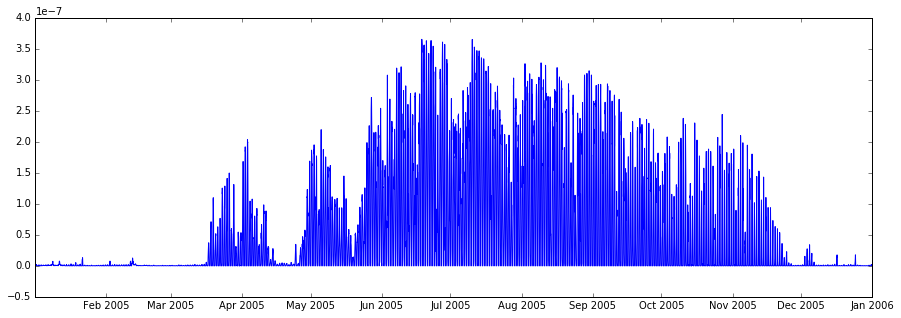

In [22]:
# Calculate the isoprene emission using the JULES scheme based on site GPP and met data:

#GPP = pd.rolling_mean(S_panda2['gpp'],24)*12.*(1e-9)
GPP = S_panda2['gpp']*12.*(1e-9)
#GPP = S_panda2['co2_flux']*-1.0*12.*(1e-9)
#GPP[GPP<0.]=0.
b1 = beta1
b2 = 0 - (Wc + Wl)
b3 = Wc*Wl
Wp = (0-b2-np.sqrt( (b2**2)-(4*b3*b1) ) ) /(2*b1)

b1 = beta2
b2 = 0 - (Wp + We)
b3 = Wp * We
Wj = (0-b2-np.sqrt( (b2**2)-(4*b3*b1) ) ) /(2*b1)


GPPJ = J_pandas[0]['gpp_gb']
#GPPJ=Wj

print(GPP.min())
print(Wl.min(),Wl.max())
print(GPPJ.min(),GPPJ.max())
plt.plot(GPPJ)
ISOPRENE= IEF * dw_area * ug2kg * hour2sec* (GPP/GPP_st) * FtJ * Fco2
ISOPRENE_J=IEF * dw_area * ug2kg * hour2sec* (GPPJ/GPP_st) * FtJ * Fco2J

In [23]:
(Wc*Wl).max()

2.8844904e-14

In [24]:
#ECP_iso_PS = pd.Series(ISOPRENE*(3600.*24.)*1e3,index=S_time2)
ECP_iso_PS = pd.Series(ISOPRENE*(3600.*24.)*1e3,index=S_time2)
ECP_J_iso_PS = pd.Series(ISOPRENE_J*(3600.*24.)*1e3,index=J_time)
ECP_We_iso_PS = pd.Series(ISOPRENE_We*(3600.*24.)*1e3,index=J_time)
ECP_Wc_iso_PS = pd.Series(ISOPRENE_Wc*(3600.*24.)*1e3,index=J_time)
ECP_Wl_iso_PS = pd.Series(ISOPRENE_Wl*(3600.*24.)*1e3,index=J_time)
#JULES_iso_PS = pd.Series(J_Dict['isoprene_gb']*(3600.*24.)*1e3/J_Dict['fsmc_gb'],index=J_time)
JULES_iso_PS = pd.Series(J_Dict['isoprene_gb']*(3600.*24.)*1e3,index=J_time)
SITE_iso_PS = pd.Series(S_Dict1['isoprene']*(1e-6)*24.,index=S_time1)

SITE_iso_PS=SITE_iso_PS['2005-08-01':'2005-08-16']

ISO_panda = pd.concat( [ECP_iso_PS.to_frame(),ECP_Wc_iso_PS.to_frame(),\
                        ECP_We_iso_PS.to_frame(),ECP_Wl_iso_PS.to_frame(), \
                        JULES_iso_PS.to_frame(),SITE_iso_PS.to_frame()], axis=1 )
ISO_panda=ISO_panda.dropna()
ISO_panda.columns=['ECP','ECP_We','ECP_Wc','ECP_Wl','JULES','SITE']


ISO_panda_D = ISO_panda.dropna().resample('D').mean()*24.
ISO_panda_C = ISO_panda.dropna().resample('D').count()

ISO_panda_D[ISO_panda_C['SITE']<14] = float('nan')

ISO_panda_D = ISO_panda_D-np.min(ISO_panda_D)
ISO_panda_D = ISO_panda_D/np.max(ISO_panda_D)


In [25]:
print('All timesteps:')
for run in ISO_panda:
    if run != 'SITE':
        print(str(run)+' vs SITE correlation   =',\
              ISO_panda[str(run)].corr(ISO_panda['SITE']))

print('\nDaily totals:')
for run in ISO_panda_D:
    if run != 'SITE':
        print(str(run)+' vs SITE correlation   =',\
              ISO_panda_D[str(run)].corr(ISO_panda_D['SITE']))


All timesteps:
ECP vs SITE correlation   = 0.713076481547
ECP_We vs SITE correlation   = 0.833340639989
ECP_Wc vs SITE correlation   = 0.863272329493
ECP_Wl vs SITE correlation   = 0.842189339826
JULES vs SITE correlation   = 0.882386341049

Daily totals:
ECP vs SITE correlation   = 0.561430993583
ECP_We vs SITE correlation   = 0.763435182901
ECP_Wc vs SITE correlation   = 0.815249881123
ECP_Wl vs SITE correlation   = 0.8356349665
JULES vs SITE correlation   = 0.837911028042


In [26]:
nDATA=len(ISO_panda_D.columns)
plotcolors[:nDATA]


['b', 'r', 'g', 'm', 'y', 'orange']

/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


(0, 1.2)

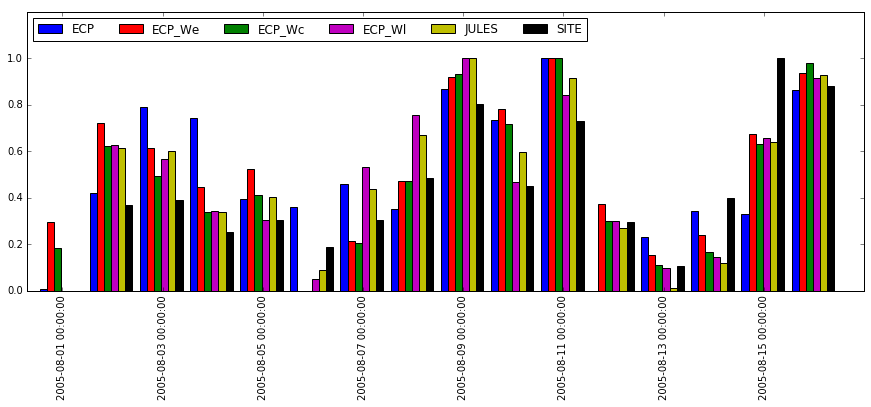

In [27]:
fig,ax=plt.subplots(ncols=1,nrows=1)
#ISO_panda_D[['ECP','SITE']].plot(kind='bar',ax=ax,width=0.85,colors=plotcolors[:nDATA-1]+['k'])
ISO_panda_D.plot(kind='bar',ax=ax,width=0.85,colors=plotcolors[:nDATA-1]+['k'])
ax.legend(ncol=len(ISO_panda_D.columns),loc=2)
#ax.locator_params(axis='x',nbins=5)
start,end=ax.get_xlim()
new_labels = ax.get_xmajorticklabels()[::2]
ax.xaxis.set_ticks(np.arange(start,end,2)+0.7)
ax.set_xticklabels(new_labels)
ax.set_ylim(0,1.2)

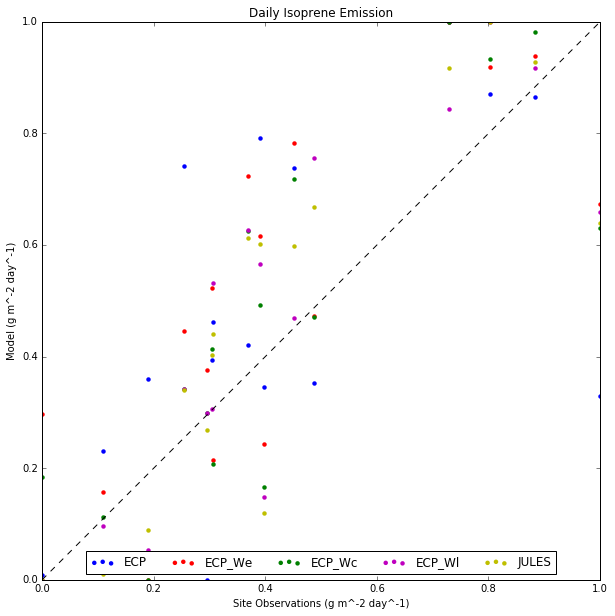

In [28]:

plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],ls='--',c='k')

for run,color in zip(ISO_panda_D,plotcolors):
    if run != 'SITE':
        plt.scatter(ISO_panda_D['SITE'],ISO_panda_D[str(run)],c=color,label=str(run),lw=0)
# plt.scatter(ISO_panda_D['SITE'],ISO_panda_D['ECP_We'],c='g',label='ECP_We',lw=0)
# plt.scatter(ISO_panda_D['SITE'],ISO_panda_D['JULES'],c='r',label='JULES',lw=0)


plt.xlim([0,1])
plt.xlabel('Site Observations (g m^-2 day^-1)')
plt.ylim([0,1])
plt.ylabel('Model (g m^-2 day^-1)')
plt.legend(loc=8,ncol=nDATA-1)
plt.title('Daily Isoprene Emission')


#SITE_iso_PS.plot()
#temp_panda=pd.concat([SITE_iso_PS,SITE_iso_PS],axis=1)
#temp_panda.plot()

In [60]:
GPP_dict={ 'SITE':GPP,'JULES':GPPJ  }  #,'JULES':GPPJ,'Wl':Wl,,'We':We,'Wc':Wc,
GPP_panda = pd.DataFrame( GPP_dict, index=J_time )
GPP_panda = GPP_panda['2005-07-01':'2005-09-01']
GPP_panda.resample('D').mean()


,JULES,SITE
2005-07-01,1.052733e-07,1.053987e-07
2005-07-02,1.004917e-07,1.256836e-07
2005-07-03,1.128692e-07,1.529778e-07
2005-07-04,9.112343e-08,9.657946e-08
2005-07-05,8.023868e-08,1.001509e-07
2005-07-06,1.148104e-07,4.350520e-08
2005-07-07,9.452352e-08,4.344992e-08
2005-07-08,1.312958e-07,7.033010e-08
2005-07-09,1.197896e-07,1.443955e-07
2005-07-10,1.746620e-07,1.577810e-07


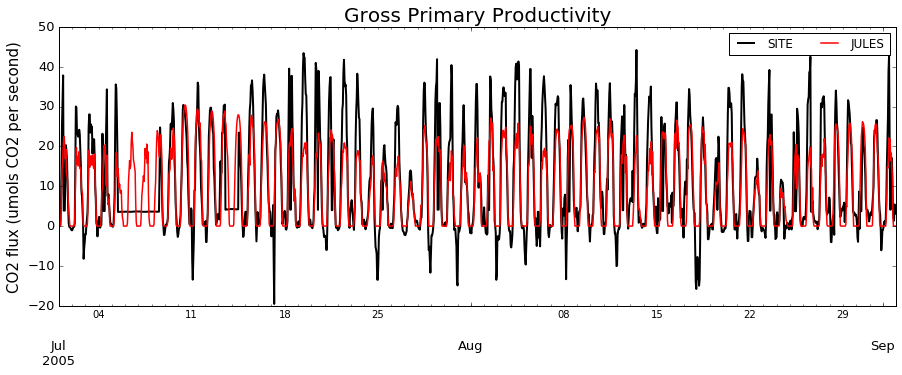

In [64]:
(GPP_panda['SITE']*kgC_to_umolsCO2_factor).plot(color='k',lw=2)
(GPP_panda['JULES']*kgC_to_umolsCO2_factor).plot(color='r',lw=1.5)
plt.title('Gross Primary Productivity',fontsize=20)
plt.legend(ncol=5)
plt.ylabel('CO2 flux (umols CO2 per second)', fontsize=15)
plt.tick_params(labelsize=13)

([<matplotlib.axis.XTick at 0x7f392c6d8e10>,
 <a list of 9 Text xticklabel objects>)

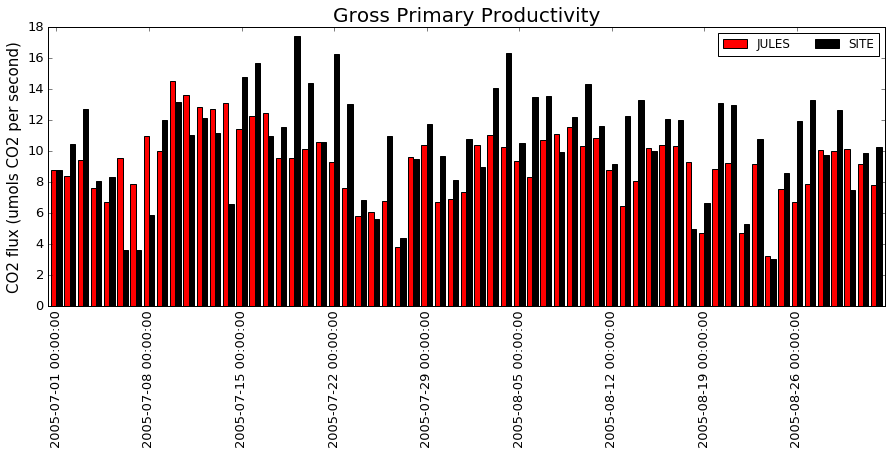

In [65]:
colors=['r','k']
(GPP_panda*kgC_to_umolsCO2_factor).resample('D').mean().plot(kind='bar',color=colors,width=0.8)
plt.title('Gross Primary Productivity',fontsize=20)
plt.legend(ncol=5)
plt.ylabel('CO2 flux (umols CO2 per second)', fontsize=15)
plt.tick_params(labelsize=13)
xlocs,xlabels=plt.xticks()
plt.xticks(xlocs[::7],xlabels[::7])


Help on function xticks in module matplotlib.pyplot:

xticks(*args, **kwargs)
    Get or set the *x*-limits of the current tick locations and labels.
    
    ::
    
      # return locs, labels where locs is an array of tick locations and
      # labels is an array of tick labels.
      locs, labels = xticks()
    
      # set the locations of the xticks
      xticks( arange(6) )
    
      # set the locations and labels of the xticks
      xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )
    
    The keyword args, if any, are :class:`~matplotlib.text.Text`
    properties. For example, to rotate long labels::
    
      xticks( arange(12), calendar.month_name[1:13], rotation=17 )

[ 0.   0.2  0.4  0.6  0.8  1. ] <a list of 6 Text xticklabel objects>


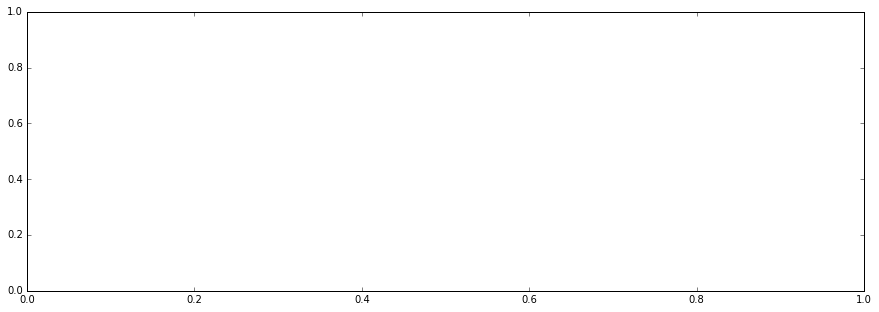

In [51]:
help(plt.xticks)
xlocs,xlabels=plt.xticks()
print(xlocs,xlabels)

In [ ]:
#ISO_panda=pd.concat( [panda['isoprene_gb'] for panda in J_pandas],axis=1)  #S_panda['isoprene']] +
#ISO_panda.columns=runids   # ['Site']+

TERP_panda=pd.concat( [panda['terpene_gb']*3.6e12 for panda in J_pandas],axis=1)
TERP_panda.columns=runids

LAI_panda=pd.concat( [panda['lai'] for panda in J_pandas],axis=1)
LAI_panda.columns=runids

TSTAR_panda=pd.concat( [panda['tstar_gb'] for panda in J_pandas],axis=1)
TSTAR_panda.columns=runids

In [ ]:
(ISO_panda*1e3*(3600.*24)).plot()

In [ ]:

#(S_panda1['isoprene']*(1e-6)).resample('D').sum().plot(kind='bar')

PLOT_PANDA=pd.concat( [S_panda1['isoprene']*(1e-6),ISO_panda*3.6e6],axis=1 )
PLOT_PANDA.resample('D').sum().plot()


In [ ]:
ax=plt.subplot(1,1,1)
(S_panda1['isoprene']*(1e-6)).resample('D').sum().plot(c='r',lw=2,grid=True,ax=ax)
(ISO_panda*3.6e6*(365*24)).plot(ax=ax,colors=['b','g','k'])
plt.ylabel('Flux (g m^-2 yr^-1)')

In [ ]:
(J_pandas[2]['isoprene_gb'][180*48:240*48]*3.6e6*(365*24)).plot()

In [ ]:
#TERP_panda.plot()
(LAI_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('LAI (m^2 m^-2')
plt.ylim([0,4])

In [ ]:
#TERP_panda.plot()
(TSTAR_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('Tstar (K)')


In [ ]:

(TERP_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('Flux (ug m^-2 h^-1')